In [1]:
import xarray as xr
import pandas as pd
import os
import datetime
import pandas as pd
import xarray as xr
import boto3
import s3fs
from io import StringIO
import time
import tempfile
import logging
import numpy as np

In [2]:
def qaqc_ds_to_df(ds, verbose=False):
    """Converts xarray ds for a station to pandas df in the format needed for the pipeline

    Parameters
    ----------
    ds : xr.Dataset
        input data from the clean step
    verbose : bool, optional
        if True, provides runtime output to the terminal

    Returns
    -------
    df : pd.DataFrame
        converted xr.Dataset into dataframe
    MultiIndex : pd.Index
        multi-index of station and time
    attrs : list of str
        attributes from xr.Dataset
    var_attrs : list of str
        variable attributes from xr.Dataset
    era_qc_vars : list of str
        QAQC variables
    """

    ## Add qc_flag variable for all variables, including elevation;
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key, val in ds.variables.items():
        if val.dtype == object:
            if key == "station":
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)

    exclude_qaqc = [
        "time",
        "station",
        "lat",
        "lon",
        "qaqc_process",
        "sfcWind_method",
        "pr_duration",
        "pr_depth",
        "PREC_flag",
        "rsds_duration",
        "rsds_flag",
        "anemometer_height_m",
        "thermometer_height_m",
    ]  # lat, lon have different qc check

    raw_qc_vars = []  # qc_variable for each data variable, will vary station to station
    era_qc_vars = []  # our ERA qc variable
    # old_era_qc_vars = []  # our ERA qc variable

    for var in ds.data_vars:
        if "q_code" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variable, need to keep for comparison, then drop
        if "_qc" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop

    # logger.info("Existing era_qc variables: {}".format(era_qc_vars))

    # only in-fill nans for valid variables
    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc"  # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})
                era_qc_vars.append(qc_var)
                print(
                    "nans created for {}".format(qc_var),
                )
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})

    n_qc = len(era_qc_vars)  # determine length of eraqc variables per station
    # logger.info("Created {0} era_qc variables: {1}".format(n_qc, era_qc_vars))

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var: ds[var].attrs for var in list(ds.data_vars.keys())}

    # with warnings.catch_warnings():
        # warnings.filterwarnings("ignore", category=RuntimeWarning)
    df = ds.to_dataframe()

    # instrumentation heights
    if "anemometer_height_m" not in df.columns:
        try:
            df["anemometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.anemometer_height_m
            )
        except:
            # logger.info("Filling anemometer_height_m with NaN.")
            df["anemometer_height_m"] = np.ones(len(df)) * np.nan

    if "thermometer_height_m" not in df.columns:
        try:
            df["thermometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.thermometer_height_m
            )
        except:
            # logger.info("Filling thermometer_height_m with NaN.")
            df["thermometer_height_m"] = np.ones(len(df)) * np.nan

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()

    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df["station"] = station

    # Station pd.Series to str
    station = station.unique().values[0]

    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    df["day"] = pd.to_datetime(df["time"]).dt.day
    df["month"] = pd.to_datetime(df["time"]).dt.month
    df["year"] = pd.to_datetime(df["time"]).dt.year
    df["date"] = pd.to_datetime(df["time"]).dt.date

    return df, MultiIndex, attrs, var_attrs, era_qc_vars

In [9]:
# dsc = xr.open_dataset('/Users/victoriaford/Downloads/NCAWOS_KEFC.nc')
dsc = xr.open_zarr('s3://wecc-historical-wx/3_qaqc_wx/RAWS/RAWS_MIPC1.zarr')
dsc

<xarray.Dataset>
Dimensions:               (station: 1, time: 156696)
Coordinates:
  * station               (station) object 'RAWS_MIPC1'
  * time                  (time) datetime64[ns] 2002-05-11T21:15:00 ... 2022-...
Data variables: (12/27)
    accum_pr              (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    accum_pr_eraqc        (station, time) int64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    anemometer_height_m   (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    elevation             (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    elevation_eraqc       (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    hurs                  (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    ...                    ...
    tas                   (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    tas_eraqc             (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    tas_qc                (station, time) object dask.array<chunksize=(1, 39174), meta=np.ndarray>
    tdps_derived          (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    tdps_derived_eraqc    (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
    thermometer_height_m  (station, time) float64 dask.array<chunksize=(1, 39174), meta=np.ndarray>
Attributes: (12/13)
    anemometer_height_m:    nan
    barometer_elevation_m:  nan
    citation:               
    comment:                Intermediate data product: may not have been subj...
    disclaimer:             This document was prepared as a result of work sp...
    history:                MADIS_clean.py script run on 02-09-2023, 15:01:29...
    ...                     ...
    license:                
    raw_files_merged:       1
    source:                 
    station_name:           POVERTY
    thermometer_height_m:   nan
    title:                  RAWS quality controlled

In [10]:
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(dsc, verbose=False)

nans created for accum_pr_eraqc
nans created for elevation_eraqc
nans created for hurs_eraqc
nans created for pr_eraqc
nans created for rsds_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for tas_eraqc
nans created for tdps_derived_eraqc


In [11]:
df

,time,accum_pr,accum_pr_eraqc,anemometer_height_m,elevation,elevation_eraqc,hurs,hurs_eraqc,hurs_qc,lat,...,tas_qc,tdps_derived,tdps_derived_eraqc,thermometer_height_m,station,hour,day,month,year,date
0,2002-05-11 21:15:00,0.508,NaN,NaN,629.7168,NaN,33.0,NaN,nan,37.443056,...,nan,278.29,NaN,NaN,RAWS_MIPC1,21,11,5,2002,2002-05-11
1,2002-05-11 22:15:00,0.508,NaN,NaN,629.7168,NaN,34.0,NaN,nan,37.443056,...,nan,277.73,NaN,NaN,RAWS_MIPC1,22,11,5,2002,2002-05-11
2,2002-05-11 23:15:00,0.508,NaN,NaN,629.7168,NaN,32.0,NaN,nan,37.443056,...,nan,277.85,NaN,NaN,RAWS_MIPC1,23,11,5,2002,2002-05-11
3,2002-05-12 00:15:00,0.508,NaN,NaN,629.7168,NaN,30.0,NaN,nan,37.443056,...,nan,275.48,NaN,NaN,RAWS_MIPC1,0,12,5,2002,2002-05-12
4,2002-05-12 01:15:00,0.508,NaN,NaN,629.7168,NaN,30.0,NaN,nan,37.443056,...,nan,274.99,NaN,NaN,RAWS_MIPC1,1,12,5,2002,2002-05-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156691,2022-08-31 19:19:00,0.508,NaN,NaN,629.7168,NaN,40.0,NaN,nan,37.443056,...,nan,285.10,NaN,NaN,RAWS_MIPC1,19,31,8,2022,2022-08-31
156692,2022-08-31 20:19:00,0.508,NaN,NaN,629.7168,NaN,32.0,NaN,nan,37.443056,...,nan,283.72,NaN,NaN,RAWS_MIPC1,20,31,8,2022,2022-08-31
156693,2022-08-31 21:19:00,0.508,NaN,NaN,629.7168,NaN,32.0,NaN,nan,37.443056,...,nan,283.72,NaN,NaN,RAWS_MIPC1,21,31,8,2022,2022-08-31
156694,2022-08-31 22:19:00,0.508,NaN,NaN,629.7168,NaN,35.0,NaN,nan,37.443056,...,nan,284.57,NaN,NaN,RAWS_MIPC1,22,31,8,2022,2022-08-31


In [12]:
df.pr.min(), df.pr.max(), df.pr.mean()

(0.0, 1270.0, 0.06864340085902527)

<AxesSubplot:>

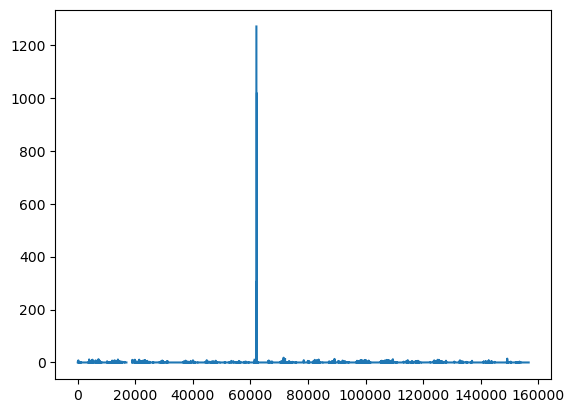

In [13]:
df.pr.plot()

In [16]:
df.loc[df.pr > 50]

,time,accum_pr,accum_pr_eraqc,anemometer_height_m,elevation,elevation_eraqc,hurs,hurs_eraqc,hurs_qc,lat,...,tas_qc,tdps_derived,tdps_derived_eraqc,thermometer_height_m,station,hour,day,month,year,date
62075,2009-10-06 02:19:00,1280.922,NaN,NaN,629.7168,NaN,NaN,NaN,nan,37.443056,...,nan,NaN,NaN,NaN,RAWS_MIPC1,2,6,10,2009,2009-10-06
62224,2009-10-15 04:19:00,315.722,NaN,NaN,629.7168,NaN,NaN,NaN,nan,37.443056,...,nan,NaN,NaN,NaN,RAWS_MIPC1,4,15,10,2009,2009-10-15
62241,2009-10-16 01:19:00,1026.922,NaN,NaN,629.7168,NaN,NaN,NaN,nan,37.443056,...,nan,NaN,NaN,NaN,RAWS_MIPC1,1,16,10,2009,2009-10-16
62256,2009-10-16 18:19:00,1026.922,NaN,NaN,629.7168,NaN,NaN,NaN,nan,37.443056,...,nan,NaN,NaN,NaN,RAWS_MIPC1,18,16,10,2009,2009-10-16


In [22]:
df.loc[(df.year == 2009) & (df.month == 10) & (df.day == 6)][['time', 'accum_pr', 'pr', 'pr_eraqc']]

,time,accum_pr,pr,pr_eraqc
62073,2009-10-06 00:19:00,10.922,0.0,NaN
62074,2009-10-06 01:19:00,10.922,0.0,NaN
62075,2009-10-06 02:19:00,1280.922,1270.0,NaN
62076,2009-10-06 03:19:00,10.922,NaN,NaN
62077,2009-10-06 04:19:00,10.922,NaN,NaN
62078,2009-10-06 05:19:00,10.922,0.0,NaN
62079,2009-10-06 06:19:00,10.922,0.0,NaN
62080,2009-10-06 07:19:00,10.922,0.0,NaN
62081,2009-10-06 08:19:00,10.922,0.0,NaN
62082,2009-10-06 11:19:00,NaN,NaN,NaN
